In [1]:
import pyro
import torch
import wandb
import os

from inference.bayesian.models import TorchModel
from inference.frequentist.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [50, 1],
            "activation": "tanh",
            "dim_reduction": False,
            "inference": "q_regr",
            "lr": 0.03,
            "num_iterations": 1000,
            "plot": True
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
Ytr, train_embedding, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 4882, Val: 1047, Te: 1047


# Quantile Regression

In [6]:
quantiles = [0.025*n for n in range(40)]
QR_torch_model = TorchModel(config.model_widths, config.activation, quantiles).to(device)

In [7]:
predictive, diagnostics = inference(config, QR_torch_model, None, X_train=train_embedding, Y_train=Ytr, 
                                    X_test=test_embedding, Y_test=Yte, num_samples=None, inference_name=None,
                                    quantiles=quantiles)

[iteration 0001] loss: 0.432034
[iteration 0101] loss: 0.111068
[iteration 0201] loss: 0.110202
[iteration 0301] loss: 0.109884
[iteration 0401] loss: 0.109697
[iteration 0501] loss: 0.109577
[iteration 0601] loss: 0.109483
[iteration 0701] loss: 0.109401
[iteration 0801] loss: 0.109328
[iteration 0901] loss: 0.109261


<Figure size 600x600 with 0 Axes>

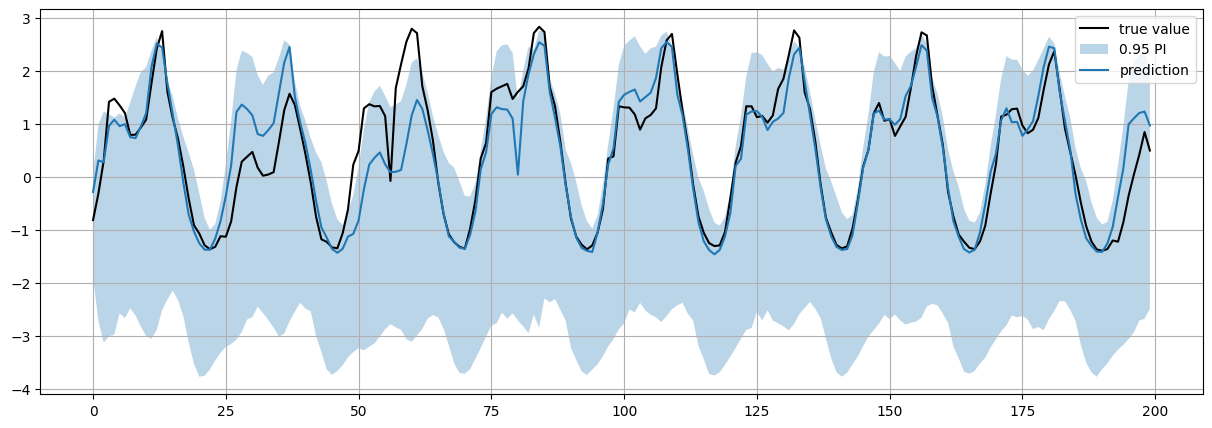

In [8]:
plot_forecast(predictive, Yte)

In [9]:
for k, v in diagnostics.items():
    print(k)

train_time
quantiles
avg_length
cal_error


In [10]:
print("training time: ", diagnostics['train_time'])
print("calibration error: ", diagnostics['cal_error'])

training time:  4.84375
calibration error:  0.1437526397794583
